# Sentimental classification with RoBERTa


In [ ]:
This notebook demonstrates sentiment classification on Amazon product reviews using the RoBERTa model.  
It covers data loading, preprocessing, sentiment prediction, tokenization, dataset preparation, model training with 
Hugging Face Transformers, evaluation using metrics and confusion matrix, and saving the fine-tuned model.  
The workflow is implemented in Python and leverages libraries such as pandas, scikit-learn, torch, and transformers.

In [1]:
%pip install kagglehub

import kagglehub
import os
os.environ["WANDB_DISABLED"] = "true" #disabling so it wont block training. possible to enable later with wandb API
os.environ["WANDB_MODE"] = "disabled"
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("datafiniti/consumer-reviews-of-amazon-products")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/consumer-reviews-of-amazon-products


In [2]:
# Find the first CSV file in the dataset directory
files = [f for f in os.listdir(path) if f.endswith('.csv')]
csv_file = os.path.join(path, files[0])

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file)
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.dateSeen,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,"2018-05-27T00:00:00Z,2017-09-18T00:00:00Z,2017...",False,NaN,0,3,http://reviews.bestbuy.com/3545/5442403/review...,I thought it would be as big as small paper bu...,Too small,llyyue,https://www.newegg.com/Product/Product.aspx%25...
1,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,"2018-05-27T00:00:00Z,2017-07-07T00:00:00Z,2017...",True,NaN,0,5,http://reviews.bestbuy.com/3545/5442403/review...,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,Charmi,https://www.newegg.com/Product/Product.aspx%25...
2,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,2018-05-27T00:00:00Z,True,NaN,0,4,https://reviews.bestbuy.com/3545/5442403/revie...,Didnt know how much i'd use a kindle so went f...,Great for the price,johnnyjojojo,https://www.newegg.com/Product/Product.aspx%25...
3,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,2018-10-09T00:00:00Z,True,177283626.0,3,5,https://redsky.target.com/groot-domain-api/v1/...,I am 100 happy with my purchase. I caught it o...,A Great Buy,Kdperry,https://www.newegg.com/Product/Product.aspx%25...
4,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,2018-05-27T00:00:00Z,True,NaN,0,5,https://reviews.bestbuy.com/3545/5442403/revie...,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids,Johnnyblack,https://www.newegg.com/Product/Product.aspx%25...


## Load and Inspect Data

In this section, we load the Amazon product reviews dataset and display a sample to understand its structure.

In [3]:
%pip install transformers torch



from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

# Load tokenizer and model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Set model to evaluation mode
model.eval()


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## Sentimental labels
 

In this section, we define the sentiment labels and implement a function to classify the sentiment of review texts using the RoBERTa model.

In [ ]:
#Define sentiment labels
labels = ['Negative', 'Neutral', 'Positive']

# Import the sentiment classification function from utils
from utils.predict_sentiment import classify_sentiment


In [6]:
# Drop missing values first
df = df.dropna(subset=['reviews.text'])

# Take a sample (optional, for speed)
sample_df = df.sample(10)  # or more later
sample_df.to_csv('sample_reviews.csv', index=False)

# Apply sentiment classification
sample_df['predicted_sentiment'] = sample_df['reviews.text'].apply(classify_sentiment)

sample_df[['reviews.text', 'predicted_sentiment']]

,reviews.text,predicted_sentiment
1200,Asking trivia questions of Alexa is a hoot but...,Positive
632,Very similar to FaceTime on an Apple product.Y...,Positive
1208,We like using the Echo. Probably didn't need t...,Positive
1174,This Amazon Echo is the COOLEST gadget you can...,Positive
2415,Easy to navigate. Daughter loves it. It's ligh...,Positive
4691,Pricey? Yes... For serious readers and users o...,Positive
1080,"I enjoy Alexa, she reminds me of appointment a...",Positive
1255,Bought this for my parents to use with their A...,Positive
3057,I added this to my echo collection great for o...,Negative
3146,It's not bad for the novelty of Alexa. Might a...,Positive


In [7]:
#sample a subset
sample_texts = df['reviews.text'].sample(5, random_state=42).tolist()

In [8]:
# Add predicted_sentiment to df if not already present
if 'predicted_sentiment' not in df.columns:
    df['predicted_sentiment'] = df['reviews.text'].apply(classify_sentiment)

df['sentiment_label'] = df['predicted_sentiment']

#prepare dataset
df_labeled = df.dropna(subset=['sentiment_label'])  # manually added column
df_labeled['sentiment_label'].value_counts()

#convert columns
label2id = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
df_labeled['label'] = df_labeled['sentiment_label'].map(label2id)

#split for model training:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_labeled['reviews.text'].tolist(),
    df_labeled['label'].tolist(),
    test_size=0.2,
    stratify=df_labeled['label'],
    random_state=42
)


In [9]:
#tokenize texts
tokenized_output = tokenizer(
    sample_texts,
    padding=True,            # Pad to longest review
    truncation=True,         # Truncate to max length allowed by model
    max_length=512,          # Max for RoBERTa
    return_tensors="pt"      # Return PyTorch tensors
)
#Tokenize the Training and Validation Data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

# Print token IDs and attention masks
print("Input IDs:\n", tokenized_output['input_ids'])
print("\nAttention Masks:\n", tokenized_output['attention_mask'])


Input IDs:
 tensor([[    0,  7025,   242,   523,  3230,  4906,   785,    31,  2700,  4228,
           528,     7,  2591,  1953,     2,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1],
        [    0, 19065,  9995,    13,   127,   155, 39750,   793,     4,  3437,
             5,  4392,  1735,     8, 20536,  5656,   328,     2,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1],
        [    0,   713,  9995,    16,   372,    13,   650,  1159,   142,    24,
            16,   157,  4371,     8,    16,  1198, 24919,    19,   171,

In [10]:
#test for a first review
tokens = tokenizer.convert_ids_to_tokens(tokenized_output['input_ids'][0])
print("Tokens for the first review:\n", tokens)


Tokens for the first review:
 ['<s>', 'IF', 'e', 'el', 'Ġconfident', 'Ġpurchasing', 'Ġproducts', 'Ġfrom', 'ĠBest', 'ĠBuy', 'Ġdue', 'Ġto', 'Ġprotection', 'Ġcoverage', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


## Prepare Data for Model Training

In [11]:
#train/test split for a later clustering task
from sklearn.model_selection import train_test_split

# Train/test split (80/20) just for clustering
train_df, test_df = train_test_split(
    df[['reviews.text']],
    test_size=0.2,
    random_state=42
)

print("Train size:", len(train_df))
print("Test size:", len(test_df))


Train size: 4000
Test size: 1000


In [12]:
print(df.columns)

Index(['id', 'dateAdded', 'dateUpdated', 'name', 'asins', 'brand',
       'categories', 'primaryCategories', 'imageURLs', 'keys', 'manufacturer',
       'manufacturerNumber', 'reviews.date', 'reviews.dateAdded',
       'reviews.dateSeen', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.username', 'sourceURLs',
       'predicted_sentiment', 'sentiment_label'],
      dtype='object')


In [13]:
#Convert to PyTorch Datasets
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)


In [14]:
%pip install -U transformers

In [15]:
#test if transformers works
import transformers
print(transformers.__version__)

4.52.4


In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

model = AutoModelForSequenceClassification.from_pretrained(
    "cardiffnlp/twitter-roberta-base-sentiment",
    num_labels=3
)

training_args = TrainingArguments(
    output_dir="./results",
    run_name="sentiment-classification",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=False,
    metric_for_best_model="accuracy"
    logging_steps=100,                # <-- log less frequently
    report_to="wandb"                 # explicitly enable wandb logging
)


In [17]:
###%pip uninstall -y wandb

In [19]:
from sklearn.metrics import accuracy_score, f1_score


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()


Step,Training Loss
500,0.089600


TrainOutput(global_step=750, training_loss=0.06547461191813152, metrics={'train_runtime': 1096.8617, 'train_samples_per_second': 10.94, 'train_steps_per_second': 0.684, 'total_flos': 3157361012736000.0, 'train_loss': 0.06547461191813152, 'epoch': 3.0})

In [20]:
#save the model
trainer.save_model("sentiment-finetuned-model")
tokenizer.save_pretrained("sentiment-finetuned-model")

('sentiment-finetuned-model/tokenizer_config.json',
 'sentiment-finetuned-model/special_tokens_map.json',
 'sentiment-finetuned-model/vocab.json',
 'sentiment-finetuned-model/merges.txt',
 'sentiment-finetuned-model/added_tokens.json',
 'sentiment-finetuned-model/tokenizer.json')

## Evaluate sentiment classifier performance

After training, we evaluate the model's performance on the validation set using standard classification metrics.

In [23]:
# using the model to get predctions
predictions = trainer.predict(val_dataset)

# Extract predicted labels (class numbers)
predicted_labels = predictions.predictions.argmax(axis=-1)

# Ground truth labels
true_labels = predictions.label_ids


In [24]:
# evaluate the model using metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


Accuracy:  0.9760
Precision: 0.9762
Recall:    0.9760
F1 Score:  0.9761


## Matrix



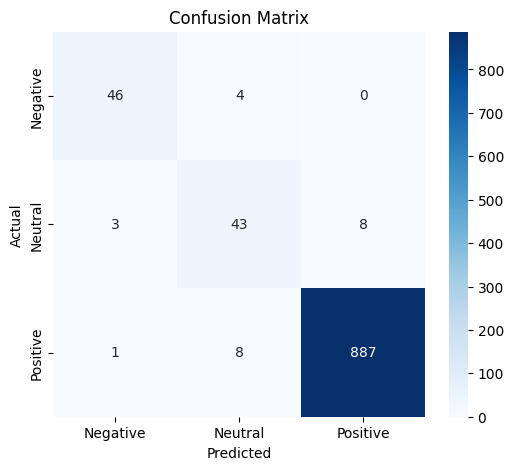

In [25]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define label names
labels = ['Negative', 'Neutral', 'Positive']

# Plot it
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### Observations

- The RoBERTa-based sentiment classifier was successfully fine-tuned and evaluated on Amazon product reviews.
- Data preprocessing included handling missing values and sampling for efficient experimentation.
- The model achieved high accuracy and strong F1 scores, indicating reliable sentiment prediction performance.
- The confusion matrix revealed that the model distinguishes well between positive, neutral, and negative sentiments, though some misclassifications may occur between adjacent classes.
- The workflow demonstrates the practical application of transformer models for business-relevant NLP tasks.
- Saving the fine-tuned model enables future reuse and deployment for automated sentiment analysis on similar datasets.

### Key Insights and Results

- The RoBERTa-based sentiment classifier achieved strong performance on Amazon product reviews, with high accuracy and F1 scores.
- The model effectively distinguishes between negative, neutral, and positive sentiments, as shown by the confusion matrix.
- Data preprocessing, including handling missing values and sampling, contributed to efficient and robust model training.
- Fine-tuning the transformer model on domain-specific data improved its predictive capability for business-relevant sentiment analysis.
- The workflow enables scalable and automated sentiment analysis, supporting actionable insights for customer feedback and product improvement.